In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports:

In [2]:
#all  imports
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from math import isnan
from networkx.algorithms.community.centrality import girvan_newman

All functions:

In [3]:
#read all data from CSV file, and show info about duplicates in it
def readFromCsvCheckDuplicates(filePath):
    temp = pd.read_csv(filePath)
    print("Dimensions of data: " + str(temp.shape))
    tempDuplicates = temp[temp.duplicated()]
    if tempDuplicates.shape[0] == 0:
        print("No duplicates in data")
    else:
        print("Duplicates are:")
        print(tempDuplicates)
    return temp
#plot all data from column in dataframe
def plot_column(nameOfColumn):
    atp_matches_data_2019.groupby(nameOfColumn)['id']\
        .nunique().plot(kind='bar')
    plt.show()
#check if column contains nulls, and if it is unique
def checkColumnNullsAndUnique(dataTmp):
    for column in dataTmp.columns:
        print(column+"\\\t"+ str(dataTmp[column].isnull().values.any())
              + "\\\t"+str(dataTmp[column].is_unique))
#set default values for rank and points if they are nulls
def checkNullsRankAndPoints(rankColumn, rankPointsColumn):
    maska = (atp_matches_data_2019[rankColumn].isnull())
    for index, row in atp_matches_data_2019[maska].iterrows():
        atp_matches_data_2019.at[index,rankColumn] = 2272
        atp_matches_data_2019.at[index,rankPointsColumn] = 0

Reading and cleaning data:

In [4]:
#read all matches from 2019
atp_matches_data_2019 = readFromCsvCheckDuplicates("atp_matches_2019.csv")

Dimensions of data: (2781, 49)
No duplicates in data


In [5]:
#read all player info
atp_players_data_info = readFromCsvCheckDuplicates("atp_players.csv")

Dimensions of data: (54975, 6)
No duplicates in data


In [6]:
#read only 2019 atp ranking data
data_rankings_atp_10s = readFromCsvCheckDuplicates("atp_rankings_10s.csv")
data_rankings_atp_10s = data_rankings_atp_10s[
    (data_rankings_atp_10s['ranking_date'] >= 20190101) &
    (data_rankings_atp_10s['ranking_date'] < 20200101)]
data_rankings_atp_10s = data_rankings_atp_10s.drop_duplicates()
print(data_rankings_atp_10s.shape)

Dimensions of data: (916296, 4)
Duplicates are:
        ranking_date  rank  player  points
855847      20181231     1  104925  9045.0
855849      20181231     2  104745  7480.0
855851      20181231     3  103819  6420.0
855853      20181231     4  100644  6385.0
855855      20181231     5  105223  5300.0
...              ...   ...     ...     ...
857194      20181231   672  201945     1.0
857196      20181231   676  126106     1.0
857198      20181231   677  106156     1.0
857200      20181231   677  126091     1.0
857202      20181231   677  126273     1.0

[678 rows x 4 columns]
(59093, 4)


In [7]:
#add id column to matches data
atp_matches_data_2019['id'] = atp_matches_data_2019.index
print(atp_matches_data_2019.shape)

(2781, 50)


In [8]:
#delete unnecessary columns from matches data
list_to_delete_columns = ['draw_size', 'match_num', 'winner_seed',
                          'winner_entry', 'winner_ht', 'loser_ht',
                          'loser_seed', 'loser_entry', 'score',
                          'best_of', 'minutes', 'w_ace', 'w_df',
                          'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
                          'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace',
                          'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
                          'l_2ndWon', 'l_SvGms', 'l_bpSaved',
                          'l_bpFaced', 'winner_name', 'winner_hand',
                          'winner_age', 'winner_ioc', 'loser_name',
                          'loser_hand', 'loser_age', 'loser_ioc']
for column in list_to_delete_columns:
    del atp_matches_data_2019[column]
print(atp_matches_data_2019.shape)

(2781, 13)


In [9]:
#plotting all columns
#for column in atp_matches_data.columns:
   # plot_column(column)

In [10]:
#set default values if null in winner and loser rank and points data
checkNullsRankAndPoints('winner_rank','winner_rank_points')
checkNullsRankAndPoints('loser_rank','loser_rank_points')

In [11]:
#check if columns are nulls or unique
checkColumnNullsAndUnique(atp_matches_data_2019)
print('---------------------------------------')
checkColumnNullsAndUnique(atp_players_data_info)

tourney_id\	False\	False
tourney_name\	False\	False
surface\	False\	False
tourney_level\	False\	False
tourney_date\	False\	False
winner_id\	False\	False
loser_id\	False\	False
round\	False\	False
winner_rank\	False\	False
winner_rank_points\	False\	False
loser_rank\	False\	False
loser_rank_points\	False\	False
id\	False\	True
---------------------------------------
id\	False\	True
name\	True\	False
surname\	True\	False
hand\	False\	False
date_of_birth\	True\	False
country\	True\	False


In [12]:
#get all players from all matches
list_winner_id = set(atp_matches_data_2019['winner_id'].unique())
list_loser_id = set(atp_matches_data_2019['loser_id'].unique())
all_current_user_ids = list_winner_id.union(list_loser_id)
print(len(all_current_user_ids))

364


Making Graph:

In [13]:
#counting different tourneys
all_pairs_player_tourney = set()
for _,row in atp_matches_data_2019.iterrows():
   all_pairs_player_tourney.add((row['winner_id'], row['tourney_id']))
   all_pairs_player_tourney.add((row['loser_id'], row['tourney_id']))

tourneys_counter_by_player = {}
for pair in all_pairs_player_tourney:
    if pair[0] in tourneys_counter_by_player.keys():
        tourneys_counter_by_player[pair[0]] +=1
    else:
        tourneys_counter_by_player[pair[0]]=1


In [14]:
#putting all nodes in graph
G = nx.Graph()
for userId in all_current_user_ids:
    player = atp_players_data_info[atp_players_data_info['id']==userId]
    all_player_rankings = data_rankings_atp_10s[data_rankings_atp_10s['player']==userId]
    temp_rank = all_player_rankings['rank'].dropna().mean()
    if isnan(temp_rank):
        temp_rank=2272.0
    temp_points=all_player_rankings['points'].dropna().mean()
    if isnan(temp_points):
        temp_points=0.0
    G.add_node(str(userId), name=player['name'].values[0],
               surname=player['surname'].values[0],
               country=player['country'].values[0],
               hand=player['hand'].values[0],
               dateOfBirth=player['date_of_birth'].values[0],
               tourneyNum=tourneys_counter_by_player[userId],
               avgRank=temp_rank,
               avgPoints=temp_points)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 364
Number of edges: 0
Average degree:   0.0000


In [15]:
#creating edges
for _, match in atp_matches_data_2019.iterrows():
    if G.has_edge(str(match['winner_id']), str(match['loser_id'])):
        G[str(match['winner_id'])][str(match['loser_id'])]['weight']+=1
    else:
        G.add_edge(str(match['winner_id']), str(match['loser_id']), weight=1)
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']=0
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']=0

    if match['winner_id']>match['loser_id']:
        G[str(match['winner_id'])][str(match['loser_id'])]['higherId']+=1
    else:
        G[str(match['winner_id'])][str(match['loser_id'])]['lowerId']+=1
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 364
Number of edges: 2378
Average degree:  13.0659


In [16]:
#write to a file
output_path = "Basic2019.gml"
nx.write_gml(G, output_path)

In [17]:
#pitanje 2 - izbaciti citacemo iz gephija
sorted_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
for player in sorted_by_degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    print(player2)
    print(player[1])

          id    name   surname hand  date_of_birth country
6406  106421  Daniil  Medvedev    R     19960211.0     RUS
60
         id       name surname hand  date_of_birth country
643  100644  Alexander  Zverev    R     19970420.0     GER
51
          id    name surname hand  date_of_birth country
5323  105332  Benoit   Paire    R     19890508.0     FRA
51
           id      name    surname hand  date_of_birth country
26758  126774  Stefanos  Tsitsipas    R     19980812.0     GRE
51
          id             name      surname hand  date_of_birth country
6028  106043  Diego Sebastian  Schwartzman    R     19920816.0     ARG
50
           id    name     surname hand  date_of_birth country
26594  126610  Matteo  Berrettini    R     19960412.0     ITA
50
           id   name     surname hand  date_of_birth country
33414  133430  Denis  Shapovalov    L     19990415.0     CAN
49
          id  name surname hand  date_of_birth country
5302  105311  Joao   Sousa    R     19890330.0     POR
49
  

{'USA': 31, 'GER': 22, 'FRA': 22, 'ITA': 21, 'ESP': 18, 'ARG': 13, 'AUS': 12, 'SRB': 9, 'GBR': 9, 'JPN': 8, 'CAN': 8, 'RUS': 8, 'CRO': 7, 'HUN': 7, 'SUI': 6, 'CHN': 6, 'SVK': 6, 'AUT': 5, 'CZE': 5, 'BRA': 5, 'BEL': 5, 'BUL': 5, 'ISR': 4, 'RSA': 4, 'UZB': 4, 'NED': 4, 'KOR': 4, 'IND': 4, 'BIH': 4, 'THA': 3, 'GUA': 3, 'INA': 3, 'PAR': 3, 'COL': 3, 'SWE': 3, 'TUR': 3, 'POR': 3, 'DEN': 3, 'FIN': 3, 'TPE': 3, 'HKG': 3, 'ZIM': 3, 'ROU': 3, 'MEX': 3, 'ECU': 3, 'PHI': 3, 'GEO': 3, 'URU': 2, 'BAR': 2, 'UKR': 2, 'ESA': 2, 'NZL': 2, 'KAZ': 2, 'BOL': 2, 'BLR': 2, 'VEN': 2, 'SLO': 2, 'DOM': 2, 'POL': 2, 'LTU': 2, 'EGY': 2, 'CHI': 2, 'PER': 2, 'NOR': 2, 'ALG': 1, 'CYP': 1, 'LAT': 1, 'MDA': 1, 'MON': 1, 'MAR': 1, 'LIB': 1, 'QAT': 1, 'GRE': 1, 'TUN': 1}


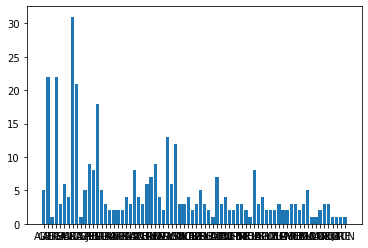

In [18]:
#pitanje 6
numOfPlayersByCountryCounter = {}
for player in G.degree:
    player2 = atp_players_data_info[atp_players_data_info['id']==(int(player[0]))]
    if player2['country'].values[0] in numOfPlayersByCountryCounter.keys():
        numOfPlayersByCountryCounter[player2['country'].values[0]] +=1
    else:
        numOfPlayersByCountryCounter[player2['country'].values[0]]=1
print(dict(sorted(numOfPlayersByCountryCounter.items(), key=lambda item: item[1], reverse=True)))
plt.bar(*zip(*numOfPlayersByCountryCounter.items()))
plt.show()

In [19]:
#prosečan weight čvora

sum = 0.0
for edge in G.edges:
    sum += G.get_edge_data(*edge)['weight']
sum /= G.number_of_edges()
print(sum)

1.1694701429772918


In [20]:
#pitanje 11
player_rank_to_edge_weight=pd.DataFrame(columns=['avgWeight', 'rank'])
for node in G.nodes:
    sum = 0.0
    counter = 0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
        counter+=1
    sum /= counter
    player_rank_to_edge_weight = player_rank_to_edge_weight.append(
        pd.DataFrame([[sum, G.nodes[node]['avgRank']]], columns=['avgWeight', 'rank']))
print(player_rank_to_edge_weight)

    avgWeight         rank
0    1.000000   125.617021
0    1.000000   190.808511
0    1.000000   567.848485
0    1.195652    38.212766
0    1.000000  1179.000000
..        ...          ...
0    1.058824   302.977778
0    1.000000   342.042553
0    1.000000   376.276596
0    1.076923   131.936170
0    1.000000   167.276596

[364 rows x 2 columns]


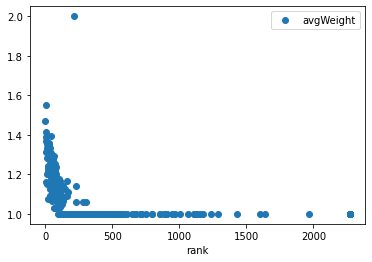

In [21]:
#pitanje 11
player_rank_to_edge_weight.plot(x='rank', y='avgWeight', style='o')
plt.show()

In [22]:
#pitanje 17
player_rank_to_degree=pd.DataFrame(columns=['degree', 'rank'])
for node in G.nodes:
    player_rank_to_degree = player_rank_to_degree.append(
        pd.DataFrame([[G.degree[node], G.nodes[node]['avgRank']]],
                     columns=['degree', 'rank']))
print(player_rank_to_degree)

   degree         rank
0      11   125.617021
0       3   190.808511
0       2   567.848485
0      46    38.212766
0       1  1179.000000
..    ...          ...
0      17   302.977778
0       2   342.042553
0       1   376.276596
0      13   131.936170
0       2   167.276596

[364 rows x 2 columns]


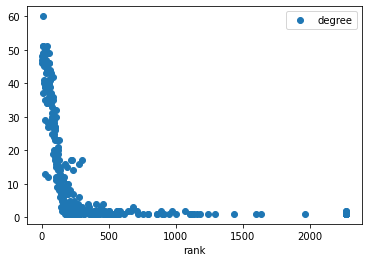

In [23]:
#pitanje 17
player_rank_to_degree.plot(x='rank', y='degree', style='o')
plt.show()

In [24]:
#klasterisanje pitanje 10
id_player, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

nonZero = [(id_ig, cc)  for id_ig, cc in zip(id_player, clustering_coef) if cc > 0]

df = pd.DataFrame(nonZero, columns = ["id", "cc"])
df.sort_values('cc', inplace = True)
print(f"Max lokalni cc: {max(clustering_coef)}")
print(f"Prosečan cc: {nx.average_clustering(G)}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
print(df)

Max lokalni cc: 0.2519842099789747
Prosečan cc: 0.13785479448611926
Lokalni stepeni klasterisanja koji nisu nula:
         id        cc
38   111200  0.007143
60   105359  0.012555
35   111190  0.013333
11   104660  0.014545
172  106329  0.019137
..      ...       ...
187  110536  0.200000
70   111576  0.200000
189  104424  0.200000
1    104460  0.217328
84   109699  0.251984

[190 rows x 2 columns]


In [25]:
#asortativnost pitanje 10
# asortativnost na osnovu netežinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G)}")

# asortativnost na osnovu težinskog stepena čvora
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: "
      f"{nx.degree_assortativity_coefficient(G, weight='weight')}")

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.1893631627055268
Koeficijent asortativnosti na osnovu težinskog stepena čvora: 0.18750548289093133


In [26]:
#pitanje 9
gn = girvan_newman(G)
print(gn)

<generator object girvan_newman at 0x1D0FA220>


In [27]:
#pitanje 9
tuple(sorted(c) for c in next(gn))

(['100644',
  '103333',
  '103819',
  '103852',
  '103893',
  '103917',
  '103970',
  '103990',
  '104122',
  '104198',
  '104259',
  '104269',
  '104291',
  '104297',
  '104312',
  '104327',
  '104386',
  '104424',
  '104460',
  '104467',
  '104468',
  '104527',
  '104534',
  '104542',
  '104545',
  '104563',
  '104571',
  '104586',
  '104607',
  '104620',
  '104629',
  '104655',
  '104656',
  '104660',
  '104665',
  '104678',
  '104719',
  '104731',
  '104735',
  '104745',
  '104755',
  '104792',
  '104797',
  '104804',
  '104810',
  '104868',
  '104871',
  '104897',
  '104898',
  '104907',
  '104918',
  '104919',
  '104925',
  '104926',
  '104970',
  '104978',
  '104999',
  '105011',
  '105015',
  '105023',
  '105041',
  '105051',
  '105053',
  '105062',
  '105063',
  '105065',
  '105074',
  '105077',
  '105091',
  '105138',
  '105147',
  '105155',
  '105156',
  '105163',
  '105166',
  '105173',
  '105208',
  '105216',
  '105217',
  '105223',
  '105226',
  '105227',
  '105254',
  '1

In [28]:
#pitanje 12
T = nx.k_core(G)
print(nx.info(T))
output_path = "core2019.gml"
nx.write_gml(T, output_path)
print(T.nodes)

Name: 
Type: Graph
Number of nodes: 79
Number of edges: 1155
Average degree:  29.2405
['126207', '105526', '200282', '105676', '144719', '106378', '106426', '104745', '106233', '126610', '105376', '105683', '105554', '106298', '105807', '106148', '105173', '104919', '111442', '106401', '104259', '104542', '104545', '105373', '105732', '105449', '105583', '105311', '104269', '103852', '134770', '106415', '106065', '100644', '105916', '105023', '106421', '126094', '105936', '106432', '111513', '200175', '104468', '103819', '106043', '111575', '105643', '105138', '105227', '104792', '105430', '111815', '105932', '200005', '104665', '106228', '200000', '104925', '132283', '200615', '104655', '104871', '104527', '126203', '128034', '104312', '111797', '106000', '105077', '126774', '104926', '105357', '133430', '105550', '124187', '105777', '105062', '105332', '105453']


In [29]:
#pitanje 18
h, a = nx.hits(G)
print(dict(sorted(h.items(), key=lambda item: item[1], reverse=True)))
print('----------')
print(dict(sorted(a.items(), key=lambda item: item[1], reverse=True)))

{'126774': 0.01857650468464971, '106421': 0.017117107483972244, '104925': 0.016064271572352504, '104745': 0.01584882291761924, '103819': 0.015356032558006962, '126610': 0.015079805361799073, '106233': 0.015007262094646411, '105676': 0.013981248747698925, '133430': 0.013925578383771387, '100644': 0.01373001537017156, '105526': 0.013545458621487289, '106043': 0.013361923369558083, '105138': 0.013267484500930226, '111575': 0.012774021465659851, '126203': 0.012062154150065115, '104792': 0.011743292325812518, '126094': 0.011687153770609481, '104871': 0.011463924284294963, '105550': 0.011434004682326046, '200000': 0.011341010255417545, '105332': 0.01121390955637024, '104527': 0.010815104192285659, '106426': 0.010783789221866544, '104926': 0.010689655825119448, '128034': 0.010548774368535288, '105932': 0.01039679153944093, '200282': 0.010355008198280653, '105077': 0.010302561033463546, '104542': 0.010239791152355411, '105430': 0.010216618069564344, '105807': 0.01018380161376733, '104269': 0.0

{11.0: 2, 3.0: 22, 2.0: 59, 55.0: 2, 1.0: 102, 53.0: 3, 52.0: 3, 46.0: 4, 7.0: 10, 5.0: 5, 22.0: 3, 4.0: 15, 47.0: 1, 33.0: 3, 8.0: 6, 20.0: 3, 15.0: 3, 67.0: 2, 68.0: 2, 35.0: 3, 66.0: 2, 58.0: 1, 16.0: 5, 18.0: 4, 34.0: 2, 69.0: 1, 54.0: 2, 41.0: 1, 6.0: 3, 21.0: 3, 14.0: 3, 48.0: 3, 65.0: 1, 9.0: 6, 23.0: 3, 13.0: 2, 10.0: 5, 42.0: 3, 57.0: 5, 63.0: 1, 28.0: 3, 49.0: 4, 43.0: 6, 30.0: 3, 31.0: 3, 38.0: 1, 26.0: 1, 59.0: 1, 19.0: 1, 64.0: 3, 62.0: 1, 40.0: 3, 12.0: 5, 17.0: 4, 36.0: 2, 60.0: 1, 50.0: 2, 44.0: 1, 39.0: 5, 29.0: 1, 79.0: 1, 37.0: 1, 80.0: 1, 56.0: 1}


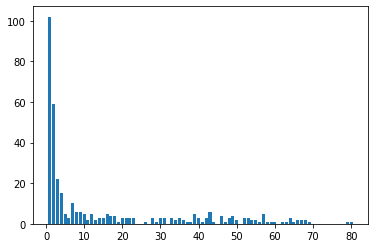

In [30]:
#pitanje 24
player_to_match_number = {}
for node in G.nodes:
    sum = 0.0
    for neighbor in nx.neighbors(G, node):
        sum+=G[node][neighbor]['weight']
    if sum in player_to_match_number.keys():
        player_to_match_number[sum]+=1
    else:
        player_to_match_number[sum]=1

print(player_to_match_number)
plt.bar(*zip(*player_to_match_number.items()))
plt.show()

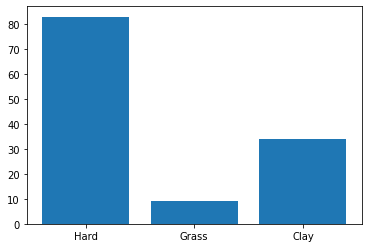

In [31]:
#pitanje 25
all_pairs_surface_tourney = set()
for _,row in atp_matches_data_2019.iterrows():
   all_pairs_surface_tourney.add((row['surface'], row['tourney_id']))

tourneys_counter_by_surface = {'Hard':0}
for pair in all_pairs_surface_tourney:
    if pair[0] in tourneys_counter_by_surface.keys():
        tourneys_counter_by_surface[pair[0]] +=1
    else:
        tourneys_counter_by_surface[pair[0]]=1
plt.bar(*zip(*tourneys_counter_by_surface.items()))
plt.show()

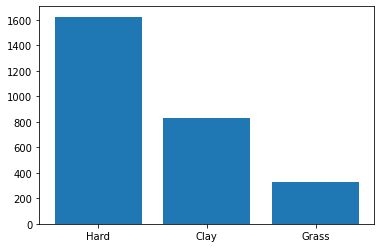

In [32]:
#pitanje 26
all_pairs_surface_matches = {}
for _,row in atp_matches_data_2019.iterrows():
   if row['surface'] in all_pairs_surface_matches.keys():
        all_pairs_surface_matches[row['surface']] += 1
   else:
        all_pairs_surface_matches[row['surface']]=1

plt.bar(*zip(*all_pairs_surface_matches.items()))
plt.show()

In [33]:
#pitanje 13
bridges = list(nx.bridges(G))
player_bridges = {}
for edge in bridges:
    if edge[0] in player_bridges.keys():
        player_bridges[edge[0]] += 1
    else:
        player_bridges[edge[0]]=1
    if edge[1] in player_bridges.keys():
        player_bridges[edge[1]] += 1
    else:
        player_bridges[edge[1]]=1
print(dict(sorted(player_bridges.items(), key=lambda item: item[1], reverse=True)))

{'105575': 3, '104655': 3, '105656': 3, '106412': 3, '105657': 3, '104467': 2, '105827': 2, '104534': 2, '110748': 2, '200553': 2, '108739': 2, '105156': 2, '106198': 2, '105497': 2, '106329': 2, '122669': 2, '208055': 2, '100644': 2, '133430': 2, '200273': 2, '105688': 2, '103893': 2, '133975': 2, '122109': 2, '105311': 2, '202358': 2, '126237': 2, '144707': 2, '105334': 2, '105376': 2, '105379': 2, '106148': 2, '105626': 2, '126190': 2, '137018': 2, '144719': 2, '106223': 2, '134770': 2, '104259': 2, '110602': 1, '105349': 1, '208937': 1, '200460': 1, '105436': 1, '104563': 1, '105807': 1, '126094': 1, '133297': 1, '105041': 1, '127157': 1, '105373': 1, '110778': 1, '105985': 1, '106232': 1, '104656': 1, '108763': 1, '104719': 1, '207134': 1, '104735': 1, '104269': 1, '207139': 1, '106150': 1, '105954': 1, '121896': 1, '209188': 1, '105015': 1, '106110': 1, '127300': 1, '209226': 1, '207182': 1, '111456': 1, '209238': 1, '104804': 1, '106216': 1, '104810': 1, '106227': 1, '104871': 1

In [34]:
# možemo iskoristiti networkx.draw_network da predstavimo egomrežu tog čvora
ego_mreza_nadal = nx.ego_graph(G, '104745')
ego_mreza_djokovic = nx.ego_graph(G, '104925')
ego_mreza_federer = nx.ego_graph(G, '103819')
output_path = "egoNadal2019.gml"
nx.write_gml(ego_mreza_nadal, output_path)
output_path = "egoDjokovic2019.gml"
nx.write_gml(ego_mreza_djokovic, output_path)
output_path = "egoFederer2019.gml"
nx.write_gml(ego_mreza_federer, output_path)
U=ego_mreza_djokovic
for node in ego_mreza_nadal.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_nadal.nodes[node]['name'],
               surname=ego_mreza_nadal.nodes[node]['surname'],
               country=ego_mreza_nadal.nodes[node]['country'],
               hand=ego_mreza_nadal.nodes[node]['hand'],
               dateOfBirth=ego_mreza_nadal.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_nadal.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_nadal.nodes[node]['avgRank'],
               avgPoints=ego_mreza_nadal.nodes[node]['avgPoints'])

for node in ego_mreza_federer.nodes:
    if not(node in U.nodes):
        U.add_node(node, name=ego_mreza_federer.nodes[node]['name'],
               surname=ego_mreza_federer.nodes[node]['surname'],
               country=ego_mreza_federer.nodes[node]['country'],
               hand=ego_mreza_federer.nodes[node]['hand'],
               dateOfBirth=ego_mreza_federer.nodes[node]['dateOfBirth'],
               tourneyNum = ego_mreza_federer.nodes[node]['tourneyNum'],
               avgRank=ego_mreza_federer.nodes[node]['avgRank'],
               avgPoints=ego_mreza_federer.nodes[node]['avgPoints'])

for edge in ego_mreza_nadal.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_nadal[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_nadal[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_nadal[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_nadal[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_nadal[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_nadal[edge[0]][edge[1]]['higherId'])
for edge in ego_mreza_federer.edges:
    if edge in U.edges:
        U[edge[0]][edge[1]]["weight"] += ego_mreza_federer[edge[0]][edge[1]]["weight"]
        U[edge[0]][edge[1]]['lowerId']+=ego_mreza_federer[edge[0]][edge[1]]['lowerId']
        U[edge[0]][edge[1]]['higherId']+=ego_mreza_federer[edge[0]][edge[1]]['higherId']
    else:
        U.add_edge(*edge, weight=ego_mreza_federer[edge[0]][edge[1]]["weight"],
                    lowerId=ego_mreza_federer[edge[0]][edge[1]]['lowerId'],
                    higherId=ego_mreza_federer[edge[0]][edge[1]]['higherId'])

output_path = "egoOfBigThree2019.gml"
nx.write_gml(U, output_path)